In [4]:
from src.data.eeg_measurement import EegMeasurement
from src.data.eeg_attention_pytorch_dataset import EegAttentionDataset
from src.evaluation.eval_vanilla_ridge import RidgeEvaluator

import numpy as np
import git
import os
import pandas
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import scipy

from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

import git
import src.data.utils as data_utils
import src.evaluation.utils as eval_utils
import pickle

import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

from os.path import join
from pandas import read_csv

In [5]:
def get_csv_log_file(base_dir, subject):
    """Return absolute path of psychopy csv log-file for given base directory and subject number
    Args:
        base_dir (str): base dir of repository
        subject (int): subject number e.g. 129
    Returns:
        string: path to csv log file of psychopy experiment
    """
    subject_folder = join(base_dir,"data","raw_input", str(subject))
    header_file = ''
    for file in os.listdir(subject_folder):
        if file.endswith('.csv'):
            header_file = file
    assert header_file.endswith('.csv'), "no file with matching datatype found!"
    assert header_file[:3] == str(subject), f"log file should start with subject number {str(subject)} but filename {header_file} was found."
    return join(subject_folder, header_file)

In [6]:
plt.rcParams["font.family"] = "Times New Roman"

In [7]:
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
subjects = list(range(102,115))
subjects = subjects + list(range(116,117))
subjects = subjects + list(range(118,126))
subjects = subjects + [127, 128, 130]

#defining some global variables
n_subjects = 25
#subjects 115 and 117 are left out --> randomisations have to be adjusted
randomisations = []
for sub in subjects:
    csv_log_path = get_csv_log_file(base_dir, sub)
    psychopy_log_file = read_csv(csv_log_path, sep=',')
    rand = psychopy_log_file.loc[0, 'randomisation']
    randomisations.append(rand)


c_cnn = '#1f77b4'
c_ridge = '#ff7f0e'

In [8]:
ridge_attended_raw_path = os.path.join(base_dir, 'reports/metrics/ridge/020/windowed_accuracies/windowed_attended_scores_raw020.pkl')
ridge_distracor_path = os.path.join(base_dir, 'reports/metrics/ridge/020/windowed_accuracies/windowed_distractor_scores_raw020.pkl')
ridge_acc_path = os.path.join(base_dir, 'reports/metrics/ridge/020/windowed_accuracies/windowed_accuracies020.npy')

cnn_attended_raw_path = os.path.join(base_dir, 'reports/metrics/cnn/152pickled_raw/attended_scores_raw.pkl')
cnn_distractor_raw_path = os.path.join(base_dir, 'reports/metrics/cnn/152pickled_raw/distractor_scores_raw.pkl')

cnn_attended_subj_raw_path = os.path.join(base_dir, 'reports/metrics/cnn/153pickled_raw/attended_scores_raw.pkl')
cnn_distractor_subj_raw_path = os.path.join(base_dir, 'reports/metrics/cnn/153pickled_raw/distractor_scores_raw.pkl')

### Loading raw reconstruction scores

Has shape (n_subjects, n_trials, window_lenghts, n_scores)

In [9]:
with open(ridge_attended_raw_path, 'rb') as f:
    ridge_attended_raw = pickle.load(f)
with open(ridge_distracor_path, 'rb') as f:
    ridge_distractor_raw = pickle.load(f)
with open(cnn_attended_raw_path, 'rb') as f:
    cnn_attended_raw = pickle.load(f)
with open(cnn_distractor_raw_path, 'rb') as f:
    cnn_distractor_raw = pickle.load(f)
with open(cnn_attended_subj_raw_path, 'rb') as f:
    cnn_attended_subj_raw = pickle.load(f)
with open(cnn_distractor_subj_raw_path, 'rb') as f:
    cnn_distractor_subj_raw = pickle.load(f)

In [10]:
#ridge_att_raw = data_utils.moveaxis(ridge_attended_raw)
#ridge_distr_raw = data_utils.moveaxis(ridge_distractor_raw)

#correct trals for subjects with randomisation 1
cnn_att_raw = data_utils.correct_trials_list(cnn_attended_raw, randomisations)
cnn_distr_raw = data_utils.correct_trials_list(cnn_distractor_raw, randomisations)

cnn_att_raw_subj = data_utils.correct_trials_list(cnn_attended_subj_raw, randomisations)
cnn_distr_raw_subj = data_utils.correct_trials_list(cnn_distractor_subj_raw, randomisations)

ridge_att_raw = data_utils.correct_trials_list(ridge_attended_raw, randomisations)
ridge_distr_raw = data_utils.correct_trials_list(ridge_distractor_raw, randomisations)

In [11]:
#elb_distr: elbenwald was in focus: scores of the distractor, meaning pol
#elb_att: elbenwald was in focus: scores of the attended, meaning elb

elb_att_ridge_raw, pol_att_ridge_raw = data_utils.get_elb_pol_attended(ridge_att_raw)
elb_distr_ridge_raw, pol_distr_ridge_raw = data_utils.get_elb_pol_attended(ridge_distr_raw)

elb_att_cnn_raw, pol_att_cnn_raw = data_utils.get_elb_pol_attended(cnn_att_raw)
elb_distr_cnn_raw, pol_distr_cnn_raw = data_utils.get_elb_pol_attended(cnn_distr_raw)

elb_att_cnn_raw_subj, pol_att_cnn_raw_subj = data_utils.get_elb_pol_attended(cnn_att_raw_subj)
elb_distr_cnn_raw_subj, pol_distr_cnn_raw_subj = data_utils.get_elb_pol_attended(cnn_distr_raw_subj)

### Extracting Scores of Elbenwald and Polarnacht independent of the focus

**For raw data we need to specify a window length, because the lists are not of equal length**

### Plotting the scores of Elbenwald and Polarnacht independent of the focus

**Sanity check to make sense of the data**

In [12]:
lin_acc_thres_list = []
lin_acc_svm_list = []
lin_elb_recall_thres_list, lin_elb_prec_thres_list, lin_elb_f1_thres_list, lin_pol_recall_thres_list, lin_pol_prec_thres_list, lin_pol_f1_thres_list = [], [], [], [], [], []

cnn_acc_thres_list = []
cnn_acc_svm_list = []
cnn_elb_recall_thres_list, cnn_elb_prec_thres_list, cnn_elb_f1_thres_list, cnn_pol_recall_thres_list, cnn_pol_prec_thres_list, cnn_pol_f1_thres_list = [], [], [], [], [], []

cnn_acc_thres_list_subj = []
cnn_acc_svm_list_subj = []
cnn_elb_recall_thres_list_subj, cnn_elb_prec_thres_list_subj, cnn_elb_f1_thres_list_subj, cnn_pol_recall_thres_list_subj, cnn_pol_prec_thres_list_subj, cnn_pol_f1_thres_list_subj = [], [], [], [], [], []

for window_index in range(0, 1):
    #create dataset for current window length
    X_lin_raw, y_lin_raw, cv_lin = eval_utils.create_dataset(elb_att_ridge_raw, elb_distr_ridge_raw, pol_att_ridge_raw, pol_distr_ridge_raw, window_index, n_subjects=n_subjects)
    X_cnn_raw, y_cnn_raw, cv_cnn = eval_utils.create_dataset(elb_att_cnn_raw, elb_distr_cnn_raw, pol_att_cnn_raw, pol_distr_cnn_raw, window_index, n_subjects=n_subjects)
    X_cnn_raw_subj, y_cnn_raw_subj, cv_cnn_subj = eval_utils.create_dataset(elb_att_cnn_raw_subj, elb_distr_cnn_raw_subj, pol_att_cnn_raw_subj, pol_distr_cnn_raw_subj, window_index, n_subjects=n_subjects)

    #eval thresholding
    lin_acc_thres, lin_elb_recall_thres, lin_elb_prec_thres, lin_elb_f1_thres, lin_pol_recall_thres, lin_pol_prec_thres, lin_pol_f1_thres = eval_utils.score_thresholding(X_lin_raw, y_lin_raw, cv_lin)
    cnn_acc_thres, cnn_elb_recall_thres, cnn_elb_prec_thres, cnn_elb_f1_thres, cnn_pol_recall_thres, cnn_pol_prec_thres, cnn_pol_f1_thres = eval_utils.score_thresholding(X_cnn_raw, y_cnn_raw, cv_cnn)
    cnn_acc_subj_thres, cnn_elb_recall_subj_thres, cnn_elb_prec_subj_thres, cnn_elb_f1_subj_thres, cnn_pol_recall_subj_thres, cnn_pol_prec_subj_thres, cnn_pol_f1_subj_thres = eval_utils.score_thresholding(X_cnn_raw_subj, y_cnn_raw_subj, cv_cnn_subj)

    #eval SVM
    lin_acc_svm, lin_elb_recall_svm, lin_elb_prec_svm, lin_elb_f1_svm, lin_pol_recall_svm, lin_pol_prec_svm, lin_pol_f1_svm = eval_utils.score_SVM(X_lin_raw,y_lin_raw, cv = cv_lin)
    cnn_acc_svm, cnn_elb_recall_svm, cnn_elb_prec_svm, cnn_elb_f1_svm, cnn_pol_recall_svm, cnn_pol_prec_svm, cnn_pol_f1_svm = eval_utils.score_SVM(X_cnn_raw,y_cnn_raw, cv = cv_cnn)
    cnn_acc_svm_subj, cnn_elb_recall_svm_subj, cnn_elb_prec_svm_subj, cnn_elb_f1_svm_subj, cnn_pol_recall_svm_subj, cnn_pol_prec_svm_subj, cnn_pol_f1_svm_subj = eval_utils.score_SVM(X_cnn_raw_subj,y_cnn_raw_subj, cv = cv_cnn_subj)

    #keep track of scores
    lin_acc_thres_list.append(lin_acc_thres)
    lin_acc_svm_list.append(lin_acc_svm)
    lin_elb_recall_thres_list.append(lin_elb_recall_thres)
    lin_elb_prec_thres_list.append(lin_elb_prec_thres)
    lin_elb_f1_thres_list.append(lin_elb_f1_thres)
    lin_pol_recall_thres_list.append(lin_pol_recall_thres)
    lin_pol_prec_thres_list.append(lin_pol_prec_thres)
    lin_pol_f1_thres_list.append(lin_pol_f1_thres)

    cnn_acc_thres_list.append(cnn_acc_thres)
    cnn_acc_svm_list.append(cnn_acc_svm)
    cnn_elb_recall_thres_list.append(cnn_elb_recall_thres)
    cnn_elb_prec_thres_list.append(cnn_elb_prec_thres)
    cnn_elb_f1_thres_list.append(cnn_elb_f1_thres)
    cnn_pol_recall_thres_list.append(cnn_pol_recall_thres)
    cnn_pol_prec_thres_list.append(cnn_pol_prec_thres)
    cnn_pol_f1_thres_list.append(cnn_pol_f1_thres)

    cnn_acc_thres_list_subj.append(cnn_acc_subj_thres)
    cnn_acc_svm_list_subj.append(cnn_acc_svm_subj)
    cnn_elb_recall_thres_list_subj.append(cnn_elb_recall_subj_thres)
    cnn_elb_prec_thres_list_subj.append(cnn_elb_prec_subj_thres)
    cnn_elb_f1_thres_list_subj.append(cnn_elb_f1_subj_thres)
    cnn_pol_recall_thres_list_subj.append(cnn_pol_recall_subj_thres)
    cnn_pol_prec_thres_list_subj.append(cnn_pol_prec_subj_thres)
    cnn_pol_f1_thres_list_subj.append(cnn_pol_f1_subj_thres)

/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/src-0.1.0-py3.11.egg/src/evaluation/utils.py:115: RuntimeWarning: invalid value encountered in scalar divide
  elb_precision_thr = true_pos / (true_pos + false_pos)


In [13]:
def sem(data):
    data = np.squeeze(np.array(data))
    return scipy.stats.sem(data)

In [14]:
#cast to numpy arrays and calculate mean

#Linear Decoding
lin_acc_thres_mean, lin_acc_svm_mean = np.mean(lin_acc_thres_list), np.mean(lin_acc_svm_list)
lin_acc_thres_sem, lin_acc_svm_sem = sem(lin_acc_thres_list), sem(lin_acc_svm_list)

lin_elb_recall_thres_mean, lin_elb_prec_thres_mean, lin_elb_f1_thres_mean = np.mean(lin_elb_recall_thres_list), np.mean(lin_elb_prec_thres_list), np.mean(lin_elb_f1_thres_list)
lin_elb_recall_thres_sem, lin_elb_prec_thres_sem, lin_elb_f1_thres_sem = sem(lin_elb_recall_thres_list), sem(lin_elb_prec_thres_list), sem(lin_elb_f1_thres_list)

lin_pol_recall_thres_mean, lin_pol_prec_thres_mean, lin_pol_f1_thres_mean = np.mean(lin_pol_recall_thres_list), np.mean(lin_pol_prec_thres_list), np.mean(lin_pol_f1_thres_list)
lin_pol_recall_thres_sem, lin_pol_prec_thres_sem, lin_pol_f1_thres_sem = sem(lin_pol_recall_thres_list), sem(lin_pol_prec_thres_list), sem(lin_pol_f1_thres_list)

lin_elb_recall_svm_mean, lin_elb_prec_svm_mean, lin_elb_f1_svm_mean = np.mean(lin_elb_recall_svm), np.mean(lin_elb_prec_svm), np.mean(lin_elb_f1_svm)
lin_elb_recall_svm_sem, lin_elb_prec_svm_sem, lin_elb_f1_svm_sem = sem(lin_elb_recall_svm), sem(lin_elb_prec_svm), sem(lin_elb_f1_svm)

lin_pol_recall_svm_mean, lin_pol_prec_svm_mean, lin_pol_f1_svm_mean = np.mean(lin_pol_recall_svm), np.mean(lin_pol_prec_svm), np.mean(lin_pol_f1_svm)
lin_pol_recall_svm_sem, lin_pol_prec_svm_sem, lin_pol_f1_svm_sem = sem(lin_pol_recall_svm), sem(lin_pol_prec_svm), sem(lin_pol_f1_svm)


#Pre-trained CNN
cnn_acc_thres_mean, cnn_acc_svm_mean = np.mean(cnn_acc_thres_list), np.mean(cnn_acc_svm_list)
cnn_acc_thresh_sem, cnn_acc_svm_sem = sem(cnn_acc_thres_list), sem(cnn_acc_svm_list)

cnn_elb_recall_thres_mean, cnn_elb_prec_thres_mean, cnn_elb_f1_thres_mean = np.mean(cnn_elb_recall_thres_list), np.nanmean(cnn_elb_prec_thres_list), np.nanmean(cnn_elb_f1_thres_list)
cnn_elb_recall_thres_sem, cnn_elb_prec_thres_sem, cnn_elb_f1_thres_sem = sem(cnn_elb_recall_thres_list), sem(cnn_elb_prec_thres_list), sem(cnn_elb_f1_thres_list)

cnn_pol_recall_thres_mean, cnn_pol_prec_thres_mean, cnn_pol_f1_thres_mean = np.mean(cnn_pol_recall_thres_list), np.mean(cnn_pol_prec_thres_list), np.mean(cnn_pol_f1_thres_list)
cnn_pol_recall_thres_sem, cnn_pol_prec_thres_sem, cnn_pol_f1_thres_sem = sem(cnn_pol_recall_thres_list), sem(cnn_pol_prec_thres_list), sem(cnn_pol_f1_thres_list)

cnn_elb_recall_svm_mean, cnn_elb_prec_svm_mean, cnn_elb_f1_svm_mean = np.mean(cnn_elb_recall_svm), np.mean(cnn_elb_prec_svm), np.mean(cnn_elb_f1_svm)
cnn_elb_recall_svm_sem, cnn_elb_prec_svm_sem, cnn_elb_f1_svm_sem = sem(cnn_elb_recall_svm), sem(cnn_elb_prec_svm), sem(cnn_elb_f1_svm)

cnn_pol_recall_svm_mean, cnn_pol_prec_svm_mean, cnn_pol_f1_svm_mean = np.mean(cnn_pol_recall_svm), np.mean(cnn_pol_prec_svm), np.mean(cnn_pol_f1_svm)
cnn_pol_recall_svm_sem, cnn_pol_prec_svm_sem, cnn_pol_f1_svm_sem = sem(cnn_pol_recall_svm), sem(cnn_pol_prec_svm), sem(cnn_pol_f1_svm)


#Not pre-trained CNN
cnn_acc_thres_mean_subj, cnn_acc_svm_mean_subj = np.mean(cnn_acc_thres_list_subj), np.mean(cnn_acc_svm_list_subj)
cnn_acc_thresh_sem_subj, cnn_acc_svm_sem_subj = sem(cnn_acc_thres_list_subj), sem(cnn_acc_svm_list_subj)

cnn_elb_recall_thres_mean_subj, cnn_elb_prec_thres_mean_subj, cnn_elb_f1_thres_mean_subj = np.mean(cnn_elb_recall_thres_list_subj), np.mean(cnn_elb_prec_thres_list_subj), np.mean(cnn_elb_f1_thres_list_subj)
cnn_elb_recall_thres_sem_subj, cnn_elb_prec_thres_sem_subj, cnn_elb_f1_thres_sem_subj = sem(cnn_elb_recall_thres_list_subj), sem(cnn_elb_prec_thres_list_subj), sem(cnn_elb_f1_thres_list_subj)

cnn_pol_recall_thres_mean_subj, cnn_pol_prec_thres_mean_subj, cnn_pol_f1_thres_mean_subj = np.mean(cnn_pol_recall_thres_list_subj), np.mean(cnn_pol_prec_thres_list_subj), np.mean(cnn_pol_f1_thres_list_subj)
cnn_pol_recall_thres_sem_subj, cnn_pol_prec_thres_sem_subj, cnn_pol_f1_thres_sem_subj = sem(cnn_pol_recall_thres_list_subj), sem(cnn_pol_prec_thres_list_subj), sem(cnn_pol_f1_thres_list_subj)

cnn_elb_recall_svm_mean_subj, cnn_elb_prec_svm_mean_subj, cnn_elb_f1_svm_mean_subj = np.mean(cnn_elb_recall_svm_subj), np.mean(cnn_elb_prec_svm_subj), np.mean(cnn_elb_f1_svm_subj)
cnn_elb_recall_svm_sem_subj, cnn_elb_prec_svm_sem_subj, cnn_elb_f1_svm_sem_subj = sem(cnn_elb_recall_svm_subj), sem(cnn_elb_prec_svm_subj), sem(cnn_elb_f1_svm_subj)

cnn_pol_recall_svm_mean_subj, cnn_pol_prec_svm_mean_subj, cnn_pol_f1_svm_mean_subj = np.mean(cnn_pol_recall_svm_subj), np.mean(cnn_pol_prec_svm_subj), np.mean(cnn_pol_f1_svm_subj)
cnn_pol_recall_svm_sem_subj, cnn_pol_prec_svm_sem_subj, cnn_pol_f1_svm_sem_subj = sem(cnn_pol_recall_svm_subj), sem(cnn_pol_prec_svm_subj), sem(cnn_pol_f1_svm_subj)

In [15]:
ridge_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/012/windowed_svm_values'
cnn_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/122/windowed_svm_valued'
cnn_path_subj = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/123/windowed_svm_valued'

lin_acc_thres_list = np.array(lin_acc_thres_list)
lin_acc_svm_list = np.array(lin_acc_svm_list)

cnn_acc_thres_list = np.array(cnn_acc_thres_list)
cnn_acc_svm_list = np.array(cnn_acc_svm_list)

cnn_acc_thres_list_subj = np.array(cnn_acc_thres_list_subj)
cnn_acc_svm_list_subj = np.array(cnn_acc_svm_list_subj)

# np.save(os.path.join(ridge_path, 'lin_acc_thres_list.npy'), lin_acc_thres_list)
# np.save(os.path.join(ridge_path, 'lin_acc_svm_list.npy'), lin_acc_svm_list)

# np.save(os.path.join(cnn_path, 'cnn_acc_thres_list.npy'), cnn_acc_thres_list)
# np.save(os.path.join(cnn_path, 'cnn_acc_svm_list.npy'), cnn_acc_svm_list)

# np.save(os.path.join(cnn_path_subj, 'cnn_acc_thres_list.npy'), cnn_acc_thres_list_subj)
# np.save(os.path.join(cnn_path_subj, 'cnn_acc_svm_list.npy'), cnn_acc_svm_list_subj)

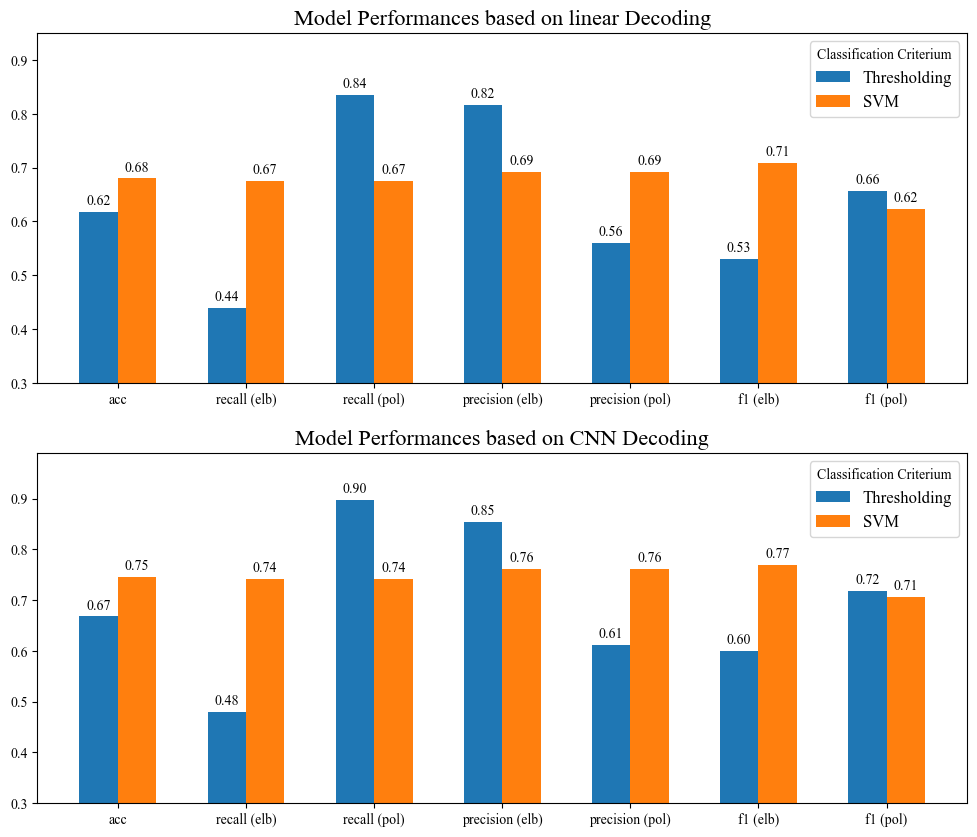

In [16]:
metrics = ('acc', 'recall (elb)', 'recall (pol)', 'precision (elb)', 'precision (pol)', 'f1 (elb)', 'f1 (pol)')
model_performances_lin = {
    'Thresholding' : (lin_acc_thres_mean, lin_elb_recall_thres_mean, lin_pol_recall_thres_mean, lin_elb_prec_thres_mean, lin_pol_prec_thres_mean, lin_elb_f1_thres_mean, lin_pol_f1_thres_mean),
    'SVM' : (lin_acc_svm_mean, lin_elb_recall_svm_mean, lin_pol_recall_svm_mean, lin_elb_prec_svm_mean, lin_pol_prec_svm_mean, lin_elb_f1_svm_mean, lin_pol_f1_svm_mean),
}

model_performances_cnn = {
    'Thresholding' : (cnn_acc_thres_mean, cnn_elb_recall_thres_mean, cnn_pol_recall_thres_mean, cnn_elb_prec_thres_mean, cnn_pol_prec_thres_mean, cnn_elb_f1_thres_mean, cnn_pol_f1_thres_mean),
    'SVM' : (cnn_acc_svm_mean, cnn_elb_recall_svm_mean, cnn_pol_recall_svm_mean, cnn_elb_prec_svm_mean, cnn_pol_prec_svm_mean, cnn_elb_f1_svm_mean, cnn_pol_f1_svm_mean),
}

x = np.arange(len(metrics))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,10))

for model, performance in model_performances_lin.items():
    rects = ax0.bar(x - width/2 + multiplier*width, performance, width, label=model)
    ax0.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Metrics', fontsize=16)
ax0.set_title('Model Performances based on linear Decoding', fontsize=16)
ax0.set_xticks(x, metrics)
ax0.legend(title='Classification Criterium', fontsize=12)
ax0.set_ylim([0.3,0.95])
#ax.grid()

for model, performance in model_performances_cnn.items():
    rects = ax1.bar(x - width/2 + multiplier*width, performance, width, label=model)
    ax1.bar_label(rects, padding=3, fmt='%.2f')
    multiplier += 1
ax1.set_xticks(x + 2* width, metrics)
ax1.set_title('Model Performances based on CNN Decoding', fontsize=16)
ax1.set_ylim([0.3,0.99])
ax1.legend(title='Classification Criterium', fontsize=12)

plt.show()

base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
fig_path = os.path.join(base_dir, 'reports', 'figures', 'learnable_thresholding')
os.makedirs(fig_path, exist_ok=True)
fig.savefig(os.path.join(fig_path, 'metrics.png'), format='png', dpi=300)
fig.savefig(os.path.join(fig_path, 'metrics.pdf'), format='pdf', dpi=300)

### Gather data for feature plane plot

In [17]:
model = SVC(kernel='linear', C=100, random_state=0)

subj = 22
X_lin_raw, y_lin_raw, cv_lin = eval_utils.create_dataset(elb_att_ridge_raw, elb_distr_ridge_raw, pol_att_ridge_raw, pol_distr_ridge_raw, window_index, n_subjects=n_subjects)
X_cnn_raw, y_cnn_raw, cv_cnn = eval_utils.create_dataset(elb_att_cnn_raw, elb_distr_cnn_raw, pol_att_cnn_raw, pol_distr_cnn_raw, window_index, n_subjects=n_subjects)
X_cnn_raw_subj, y_cnn_raw_subj, cv_cnn_subj = eval_utils.create_dataset(elb_att_cnn_raw_subj, elb_distr_cnn_raw_subj, pol_att_cnn_raw_subj, pol_distr_cnn_raw_subj, window_index, n_subjects=n_subjects)

X_train_lin, y_train_lin = X_lin_raw[cv_lin[subj][0]], y_lin_raw[cv_lin[subj][0]]
X_test_lin, y_test_lin = X_lin_raw[cv_lin[subj][1]], y_lin_raw[cv_lin[subj][1]]

X_train_cnn, y_train_cnn = X_cnn_raw[cv_cnn[subj][0]], y_cnn_raw[cv_cnn[subj][0]]
X_test_cnn, y_test_cnn = X_cnn_raw[cv_cnn[subj][1]], y_cnn_raw[cv_cnn[subj][1]]

X_train_cnn_subj, y_train_cnn_subj = X_cnn_raw_subj[cv_cnn_subj[subj][0]], y_cnn_raw_subj[cv_cnn_subj[subj][0]]
X_test_cnn_subj, y_test_cnn_subj = X_cnn_raw_subj[cv_cnn_subj[subj][1]], y_cnn_raw_subj[cv_cnn_subj[subj][1]]

clf_lin = model.fit(X_train_lin, y_train_lin)
clf_cnn = model.fit(X_train_cnn, y_train_cnn)
clf_cnn_subj = model.fit(X_train_cnn_subj, y_train_cnn_subj)

elb_attended_lin = X_train_lin[y_train_lin == 1, :]
pol_attended_lin = X_train_lin[y_train_lin == 0, :]
elb_attended_test_lin = X_test_lin[y_test_lin == 1, :]
pol_attended_test_lin = X_test_lin[y_test_lin == 0, :]

elb_attended_cnn, pol_attended_cnn = X_train_cnn[y_train_cnn == 1, :], X_train_cnn[y_train_cnn == 0, :]
elb_attended_test_cnn, pol_attended_test_cnn = X_test_cnn[y_test_cnn == 1, :], X_test_cnn[y_test_cnn == 0, :]

elb_attended_cnn_subj, pol_attended_cnn_subj = X_train_cnn_subj[y_train_cnn_subj == 1, :], X_train_cnn_subj[y_train_cnn_subj == 0, :]
elb_attended_test_cnn_subj, pol_attended_test_cnn_subj = X_test_cnn_subj[y_test_cnn_subj == 1, :], X_test_cnn_subj[y_test_cnn_subj == 0, :]


### Figure parameters

In [18]:
label_fontsize = 10
tick_fontsize = 9

#color_polarnacht ='#1f77b4'
color_elbenwald = 'slategrey'
color_polarnacht = 'darkseagreen'

# color_polarnacht = 'steelblue'
# color_elbenwald = 
#'#ff7f0e'
color_svm = 'goldenrod'
color_thres = 'steelblue'

marker_polarnacht = '^'
marker_elbenwald = 'o'

alpha_train, alpha_test = 0.4, 1
s_train = 2
s_test = 18

linestyle_diagonal = '-.'
linestyle_svm = '-'
linewidth = 1.5

axis_linewidth = 1.0

y_ticks = [0, 0.2, 0.4]

x_text_0 = -0.20
x_text_1 = 0.32

In [19]:
def plot_features_space(ax0,ax1,ax2,ax3):
    elb_train = ax0.scatter(elb_attended_lin[:,0], elb_attended_lin[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended train', alpha=alpha_train, s = s_train)
    pol_train = ax0.scatter(pol_attended_lin[:,0], pol_attended_lin[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended train', alpha=alpha_train, s = s_train)
    elb_test = ax0.scatter(elb_attended_test_lin[:,0], elb_attended_test_lin[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended test', alpha=alpha_test, s=s_test)
    pol_test = ax0.scatter(pol_attended_test_lin[:,0], pol_attended_test_lin[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended test', alpha=alpha_test, s=s_test)

    diago = ax0.plot([0, 1], [0, 1], linestyle = linestyle_diagonal, transform=ax0.transAxes, label = 'diagonal', c = color_thres, linewidth=linewidth)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf_lin,
        X_lin_raw,
        plot_method="contour",
        colors=color_svm,
        levels=[0],
        alpha=1.0,
        linestyles=[linestyle_svm],
        linewidths=[linewidth],
        label = 'svm',
        ax=ax0
    )

    ax0.set_xlim([-0.1,0.5])
    ax0.set_ylim([-0.1,0.5])

    ax0.set_xlabel(r'$r_{s1}$', fontsize = label_fontsize)
    ax0.set_ylabel(r'$r_{s2}$', fontsize = label_fontsize)
    ax0.set_title('Linear Decoding\n', fontsize=label_fontsize)
    ax0.text(x_text_0,0.58, '(a)')
    #ax0.legend(loc='lower right')
    ax0.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax0.set_yticks(y_ticks)


    ax1.scatter(elb_attended_cnn[:,0], elb_attended_cnn[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended train', alpha=alpha_train, s=s_train)
    ax1.scatter(pol_attended_cnn[:,0], pol_attended_cnn[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended train', alpha=alpha_train, s=s_train)
    ax1.scatter(elb_attended_test_cnn[:,0], elb_attended_test_cnn[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended test', alpha=alpha_test, s=s_test)
    ax1.scatter(pol_attended_test_cnn[:,0], pol_attended_test_cnn[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended test', alpha=alpha_test, s=s_test)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf_cnn,
        X_cnn_raw,
        plot_method="contour",
        colors=color_svm,
        levels=[0],
        alpha=1.0,
        linestyles=[linestyle_svm],
        linewidths=[linewidth],
        label = 'svm',
        ax=ax1,
    )

    ax1.plot([0, 1], [0, 1], linestyle = linestyle_diagonal, transform=ax1.transAxes, label = 'diagonal', c = color_thres, linewidth = linewidth)

    ax1.set_xlim([-0.1,0.5])
    ax1.set_ylim([-0.1,0.5])

    ax1.set_xlabel(r'$r_{s1}$', fontsize = label_fontsize)
    #ax1.set_ylabel(r'$r_{pol}$', fontsize = label_fontsize)
    ax1.set_title('CNN Decoding\n(pre-trained)', fontsize=label_fontsize)
    ax1.text(x_text_0,0.58, '(c)')
    #ax1.legend(loc='upper left')
    ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax1.set_yticks(y_ticks)


    ax2.scatter(elb_attended_cnn_subj[:,0], elb_attended_cnn_subj[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended train', alpha=alpha_train, s=s_train)
    ax2.scatter(pol_attended_cnn_subj[:,0], pol_attended_cnn_subj[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended train', alpha=alpha_train, s=s_train)
    ax2.scatter(elb_attended_test_cnn_subj[:,0], elb_attended_test_cnn_subj[:,1], color=color_elbenwald, marker = marker_elbenwald, label='elb attended test', alpha=alpha_test, s=s_test)
    ax2.scatter(pol_attended_test_cnn_subj[:,0], pol_attended_test_cnn_subj[:,1], color=color_polarnacht, marker = marker_polarnacht, label='pol attended test', alpha=alpha_test, s=s_test)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf_cnn_subj,
        X_cnn_raw,
        plot_method="contour",
        colors=color_svm,
        levels=[0],
        alpha=1.0,
        linestyles=[linestyle_svm],
        linewidths=[linewidth],
        label = 'svm',
        ax=ax2,
    )

    ax2.plot([0, 1], [0, 1], linestyle = linestyle_diagonal, transform=ax2.transAxes, label = 'diagonal', c = color_thres, linewidth = linewidth)

    ax2.set_xlim([-0.1,0.5])
    ax2.set_ylim([-0.1,0.5])

    ax2.set_xlabel(r'$r_{s1}$', fontsize = label_fontsize)
    #ax1.set_ylabel(r'$r_{pol}$', fontsize = label_fontsize)
    ax2.set_title('CNN Decoding\n(subject-specific)', fontsize=label_fontsize)
    ax2.text(x_text_0,0.58, '(b)')
    #ax1.legend(loc='upper left')
    ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax2.set_yticks(y_ticks)

    ax3.legend([Line2D([0], [0], color=color_svm, linewidth=linewidth, linestyle= linestyle_svm), Line2D([0], [0], color=color_thres, linewidth=linewidth, linestyle= linestyle_diagonal), 
                elb_train, pol_train, elb_test, pol_test], 
                ['SVM', 'Naive\nClassifier', 's1 attended\n(Training)', 's2 attended\n(Training)', 's1 attended\n(Test)', 's2 attended\n(Test)'], loc='center left', 
                fontsize=tick_fontsize, frameon=True)

    ax3.axis('off')

    for axis in [ax0, ax1, ax2]:
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.spines['left'].set_linewidth(axis_linewidth)
        axis.spines['bottom'].set_linewidth(axis_linewidth)

In [20]:
def plot_metrics(ax0,ax1,ax2,ax3):
    metrics = ('accuracy', 'recall (s1)', 'recall (s2)', 'precision (s1)', 'precision (s2)')
    model_performances_lin = {
        'Thresholding' : (lin_acc_thres_mean, lin_elb_recall_thres_mean, lin_pol_recall_thres_mean, lin_elb_prec_thres_mean, lin_pol_prec_thres_mean),
        'SVM' : (lin_acc_svm_mean, lin_elb_recall_svm_mean, lin_pol_recall_svm_mean, lin_elb_prec_svm_mean, lin_pol_prec_svm_mean),
    }

    sem_lin = {
        'Thresholding' : (lin_acc_thres_sem, lin_elb_recall_thres_sem, lin_pol_recall_thres_sem, lin_elb_prec_thres_sem, lin_pol_prec_thres_sem),
        'SVM' : (lin_acc_svm_sem, lin_elb_recall_svm_sem, lin_pol_recall_svm_sem, lin_elb_prec_svm_sem, lin_pol_prec_svm_sem),
    }

    model_performances_cnn = {
        'Thresholding' : (cnn_acc_thres_mean, cnn_elb_recall_thres_mean, cnn_pol_recall_thres_mean, cnn_elb_prec_thres_mean, cnn_pol_prec_thres_mean),
        'SVM' : (cnn_acc_svm_mean, cnn_elb_recall_svm_mean, cnn_pol_recall_svm_mean, cnn_elb_prec_svm_mean, cnn_pol_prec_svm_mean),
    }

    sem_cnn = {
        'Thresholding' : (cnn_acc_thresh_sem, cnn_elb_recall_thres_sem, cnn_pol_recall_thres_sem, 0.031, cnn_pol_prec_thres_sem),
        'SVM' : (cnn_acc_svm_sem, cnn_elb_recall_svm_sem, cnn_pol_recall_svm_sem, cnn_elb_prec_svm_sem, cnn_pol_prec_svm_sem),
    }


    model_performances_cnn_subj = {
        'Thresholding' : (cnn_acc_thres_mean_subj, cnn_elb_recall_thres_mean_subj, cnn_pol_recall_thres_mean_subj, cnn_elb_prec_thres_mean_subj, cnn_pol_prec_thres_mean_subj),
        'SVM' : (cnn_acc_svm_mean_subj, cnn_elb_recall_svm_mean_subj, cnn_pol_recall_svm_mean_subj, cnn_elb_prec_svm_mean_subj, cnn_pol_prec_svm_mean_subj),
    }

    sem_cnn_subj = {
        'Thresholding' : (cnn_acc_thresh_sem_subj, cnn_elb_recall_thres_sem_subj, cnn_pol_recall_thres_sem_subj, cnn_elb_prec_thres_sem_subj, cnn_pol_prec_thres_sem_subj),
        'SVM' : (cnn_acc_svm_sem_subj, cnn_elb_recall_svm_sem_subj, cnn_pol_recall_svm_sem_subj, cnn_elb_prec_svm_sem_subj, cnn_pol_prec_svm_sem_subj),
    }
    x = np.arange(len(metrics))[::-1]  # the label locations
    width = 0.3  # the width of the bars
    multiplier = 0

    for axis, model_performances, sems in zip([ax0, ax1, ax2], [model_performances_lin, model_performances_cnn, model_performances_cnn_subj], [sem_lin, sem_cnn, sem_cnn_subj]):
        for (model, performance), (_, sem) in zip(model_performances.items(), sems.items()):
            if model == 'Thresholding':
                rects_thres = axis.barh(x - width/2 + multiplier*width, performance, width, label=model, color = color_thres)
                error_bar = axis.errorbar(performance, x - width/2 + multiplier*width, xerr=sem, fmt='none', color='black', elinewidth=1.2)
                #axis.bar_label(rects_thres, padding=0, fmt='%.2f')
            else:
                rects_svm = axis.barh(x - width/2 + multiplier*width, performance, width, label=model, color = color_svm)
                error_bar = axis.errorbar(performance, x - width/2 + multiplier*width, xerr=sem, fmt='none', color='black', elinewidth=1.2)
            
            multiplier += 1
        axis.set_xlim([0.35,1.0])
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.spines['left'].set_linewidth(axis_linewidth)
        axis.spines['bottom'].set_linewidth(axis_linewidth)
        axis.set_xticks([0.5,0.7,0.9], labels = [0.5,0.7,0.9], fontsize=tick_fontsize)

        axis.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, symbol='%'))
        #axis.set_xlabel(('(%)'), fontsize = tick_fontsize)

    ax0.set_yticks(x, labels = metrics, fontsize = tick_fontsize)
    ax1.set_yticks([])
    ax2.set_yticks([])

    ax3.axis('off')
    ax3.legend([rects_svm[-1], rects_thres[-1]], ['SVM','Naive\nClassifier'], loc='center left', fontsize=tick_fontsize, frameon=True)

In [21]:
sem_lin = {
    'Thresholding' : (lin_acc_thres_sem, lin_elb_recall_thres_sem, lin_pol_recall_thres_sem, lin_elb_prec_thres_sem, lin_pol_prec_thres_sem),
    'SVM' : (lin_acc_svm_sem, lin_elb_recall_svm_sem, lin_pol_recall_svm_sem, lin_elb_prec_svm_sem, lin_pol_prec_svm_sem),
}
for (model, performance), (_, sem) in zip(model_performances_lin.items(), sem_lin.items()):
    print(model, performance, sem)

Thresholding (0.618, 0.44, 0.8355555555555556, 0.8157460317460319, 0.5596574218694961, 0.5306580075124967, 0.6566479395001135) (0.023072349974229616, 0.04317942577104698, 0.04113612852419206, 0.03377252537810876, 0.020658781022576216)
SVM (0.68, 0.6747474747474747, 0.6747474747474747, 0.6924956432456432, 0.6924956432456432, 0.7093284945413092, 0.6231875118345708) (0.019999999999999997, 0.020602099044819334, 0.020602099044819334, 0.020955058987098353, 0.020955058987098353)


/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'label'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'label'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'label'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


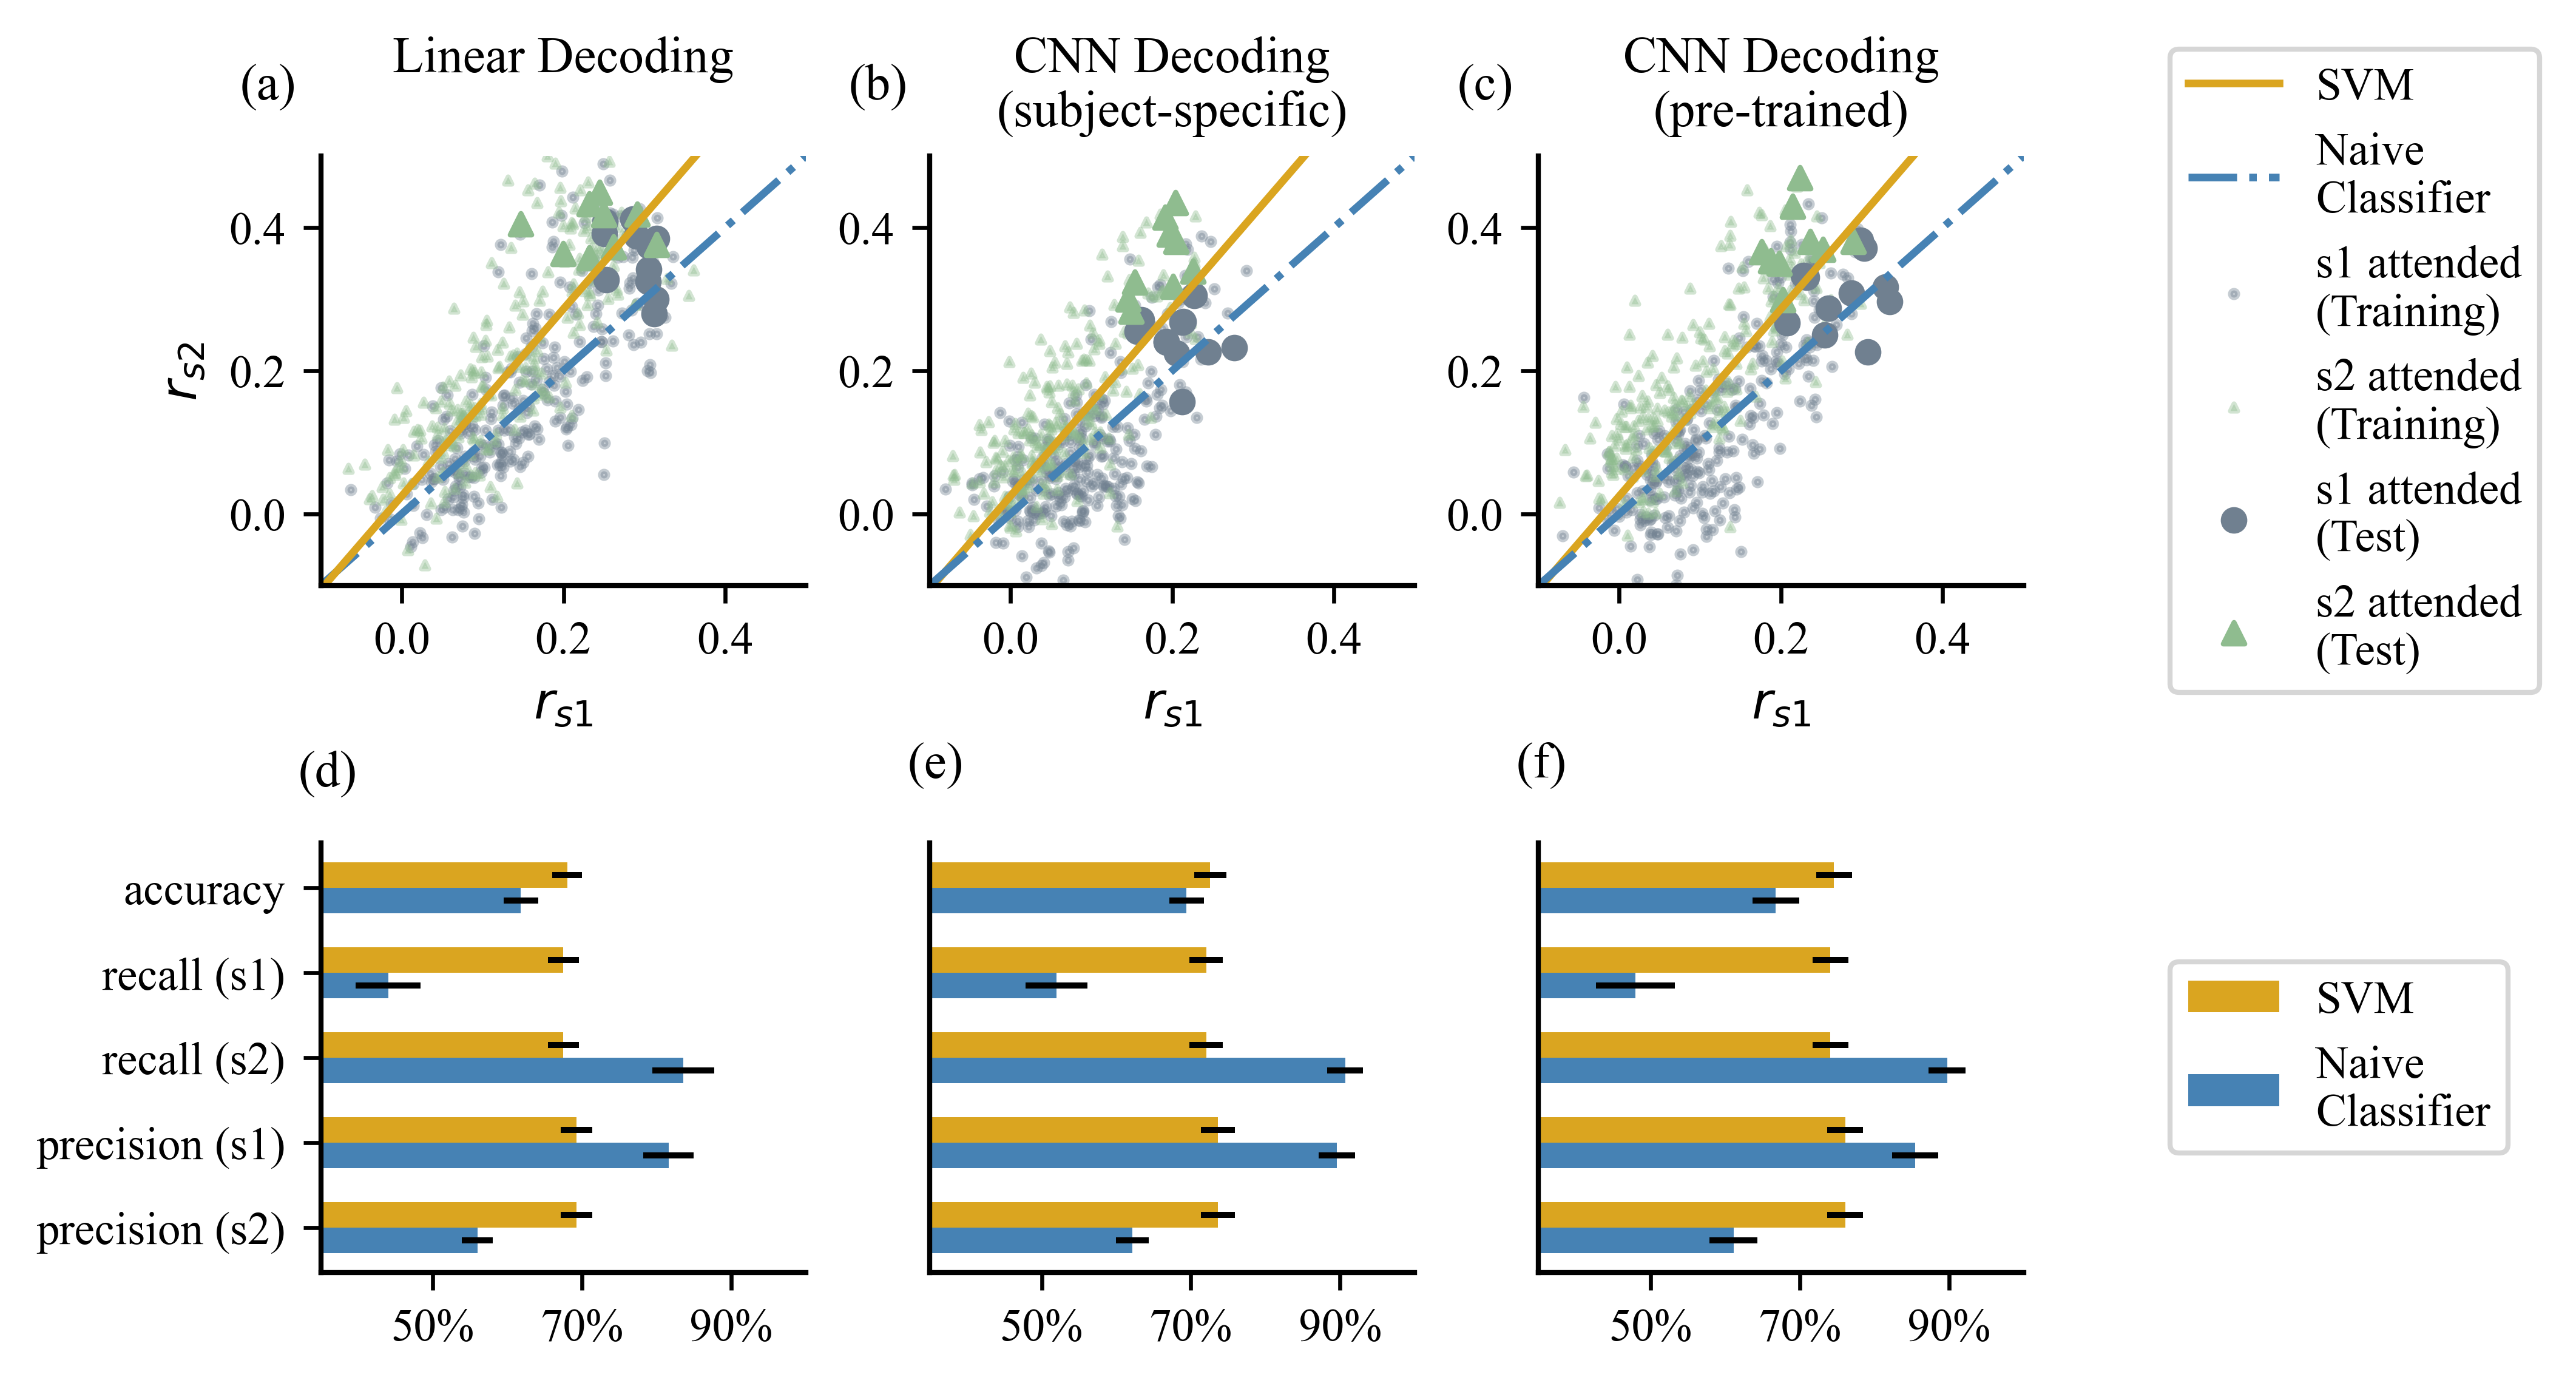

In [22]:
fig = plt.figure(figsize=(7.16,4.2), dpi=600)
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=[1, 1, 1, 0.4], wspace = 0.3, hspace = 0.6)
[[ax0, ax1, ax2, ax3], [ax4, ax5, ax6, ax7]]  = spec.subplots()
plot_features_space(ax0, ax2, ax1, ax3)

plt.subplots_adjust(bottom=0.15)
plot_metrics(ax4, ax6, ax5, ax7)
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
#plt.tight_layout()

letters = ['(d)', '(e)', '(f)']
# for ax, letter, i in zip([ax4, ax5, ax6], letters, range(0,3)):
#     #ax.set_title(letter, fontsize=label_fontsize)
ax4.text(x_text_1,5.2, letters[0])
ax5.text(x_text_1,6.5, letters[1])
ax6.text(x_text_1,5.9, letters[2])

#ax0.text(1,1, letters[0], fontsize=label_fontsize, ha='center')


fig_path = os.path.join(base_dir, 'reports', 'figures', 'learnable_thresholding')
os.makedirs(fig_path, exist_ok=True)
fig.savefig(os.path.join(fig_path, 'svm_example.png'), bbox_inches='tight', format='png', dpi=600)
fig.savefig(os.path.join(fig_path, 'svm_example.pdf'), bbox_inches='tight', format='pdf', dpi=600)
fig.savefig(os.path.join(fig_path, 'svm_example.svg'), bbox_inches='tight', format='svg', dpi=600)

In [94]:
lin_acc_thres_mean, lin_elb_recall_thres_mean, lin_pol_recall_thres_mean, lin_elb_prec_thres_mean, lin_pol_prec_thres_mean

(0.618, 0.44, 0.8355555555555556, 0.8157460317460319, 0.5596574218694961)

In [97]:
lin_acc_svm_mean, lin_elb_recall_svm_mean, lin_pol_recall_svm_mean, lin_elb_prec_svm_mean, lin_pol_prec_svm_mean

(0.68,
 0.6747474747474747,
 0.6747474747474747,
 0.6924956432456432,
 0.6924956432456432)

In [98]:
cnn_acc_thres_mean

0.6680000000000001

In [95]:
cnn_acc_svm_mean, cnn_elb_recall_svm_mean, cnn_pol_recall_svm_mean, cnn_elb_prec_svm_mean, cnn_pol_prec_svm_mean

(0.7460000000000001,
 0.7412121212121211,
 0.7412121212121211,
 0.7610265910560028,
 0.7610265910560028)

In [99]:
cnn_acc_thres_mean_subj

0.6940000000000001

In [96]:
cnn_acc_svm_mean_subj, cnn_elb_recall_svm_mean_subj, cnn_pol_recall_svm_mean_subj, cnn_elb_prec_svm_mean_subj, cnn_pol_prec_svm_mean_subj

(0.726,
 0.7206060606060605,
 0.7206060606060605,
 0.7363071650571651,
 0.7363071650571651)

In [100]:
68 - 61.8

6.200000000000003

In [101]:
74.6 - 66.8

7.799999999999997